In [151]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy as sc
from scipy import stats
import sklearn

%matplotlib inline

for file in os.listdir("house-prices-advanced-regression-techniques"):
    print(file)


sample_submission.csv
test.csv
train.csv
data_description.txt


In [152]:
train_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
train_data = train_data.drop(columns = 'Id')

In [153]:
missing_percent = (train_data.isna().sum(axis = 0) / len(train_data))
cols_to_remove = missing_percent[missing_percent > 0.5].index

In [154]:
train_data = train_data.drop(columns = cols_to_remove)

## Numerical Data
Exclude all categorical variables and only use numerical variables

In [155]:
numerical_train_data = train_data.drop(columns = train_data.columns[train_data.dtypes == 'object'])

In [156]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
train,test = train_test_split(numerical_train_data,test_size = 0.2)
train.fillna(0,inplace = True),test.fillna(0,inplace = True)
x_train,y_train = train.drop(columns = 'SalePrice').to_numpy(),train['SalePrice'].to_numpy()
x_test,y_test = test.drop(columns = 'SalePrice').to_numpy(),test['SalePrice'].to_numpy()

/home/alexhetherington/.local/lib/python3.8/site-packages/pandas/core/frame.py:5171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [157]:
x_scaler = MinMaxScaler().fit(x_train)
x_train,x_test = x_scaler.transform(x_train),x_scaler.transform(x_test)
y_scaler = MinMaxScaler().fit(y_train[:,None])
y_train,y_test = y_scaler.transform(y_train[:,None]),y_scaler.transform(y_test[:,None])

# PCA

In [158]:
from sklearn.decomposition import PCA
pca  = PCA(2)
some_x = pca.fit(x_train).transform(x_train)

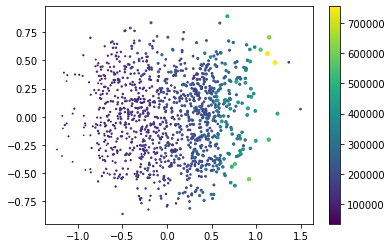

In [159]:
plt.scatter(some_x[:,0],some_x[:,1],c = y_scaler.inverse_transform(y_train),cmap = 'viridis',marker = '.',s = 60*y_train)
plt.colorbar()
print()

In [160]:
#data is not separable, no really distinct groups

#### Plotting function

In [168]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error
def rmse(_true,_pred):
    return mean_squared_error(_true,_pred,squared = 'False')

def model_quartet_plot(model):
    fig,ax = plt.subplots(nrows = 2,ncols = 2,figsize = (6,6),dpi = (120))
    
    true,pred = y_train,model.predict(x_train)
    if len(pred.shape) == 1:
        pred = pred[:,None]
    _min,_max = min(true.min(),pred.min()),max(true.max(),pred.max())
    ax[0,0].scatter(true,pred,s = 5)
    ax[0,0].plot([_min,_max],[_min,_max],'k--')
    ax[0,0].annotate('RMSE:' + str('{:.3g}'.format(rmse(true,pred))) + '\n' + '$R^2$:' + str('{:.3g}'.format(r2(true,pred))),(0.1,0.8),xycoords="axes fraction")
    
    true,pred = y_scaler.inverse_transform(true) / 1e6,y_scaler.inverse_transform(pred) / 1e6
    _min,_max = min(true.min(),pred.min()),max(true.max(),pred.max())
    ax[1,0].scatter(true,pred,s = 5)
    ax[1,0].plot([_min,_max],[_min,_max],'k--')
    ax[1,0].annotate('RMSE:' + str('{:.3g}'.format(rmse(true,pred))) + '\n' + '$R^2$:' + str('{:.3g}'.format(r2(true,pred))),(0.1,0.8),xycoords="axes fraction")
    
    true,pred = y_test,model.predict(x_test)
    if len(pred.shape) == 1:
        pred = pred[:,None]
    _min,_max = min(true.min(),pred.min()),max(true.max(),pred.max())
    ax[0,1].scatter(true,pred,c = 'red',s = 5)
    ax[0,1].plot([_min,_max],[_min,_max],'k--')
    ax[0,1].annotate('RMSE:' + str('{:.3g}'.format(rmse(true,pred))) + '\n' + '$R^2$:' + str('{:.3g}'.format(r2(true,pred))),(0.1,0.8),xycoords="axes fraction")
    
    true,pred = y_scaler.inverse_transform(true) / 1e6,y_scaler.inverse_transform(pred) / 1e6
    _min,_max = min(true.min(),pred.min()),max(true.max(),pred.max())
    ax[1,1].scatter(true,pred,c = 'red',s = 5)
    ax[1,1].plot([_min,_max],[_min,_max],'k--')
    ax[1,1].annotate('RMSE:' + str('{:.3g}'.format(rmse(true,pred))) + '\n' + '$R^2$:' + str('{:.3g}'.format(r2(true,pred))),(0.1,0.8),xycoords="axes fraction")
    
    ax[0,0].set(ylabel = 'Scaled')
    ax[1,0].set(xlabel = 'Train',ylabel = 'Raw House Price (Million $)')
    ax[1,1].set(xlabel = 'Test')
    fig.tight_layout()

### Linear Regression

This house price dataset, as expected, has a few outliers in the data. These are generally the very expensive properties that are only really expensive because of very difficult to predict attributes. Factors affecting house prices of mansions are very likely to be different compared with factors that affect generic housing.

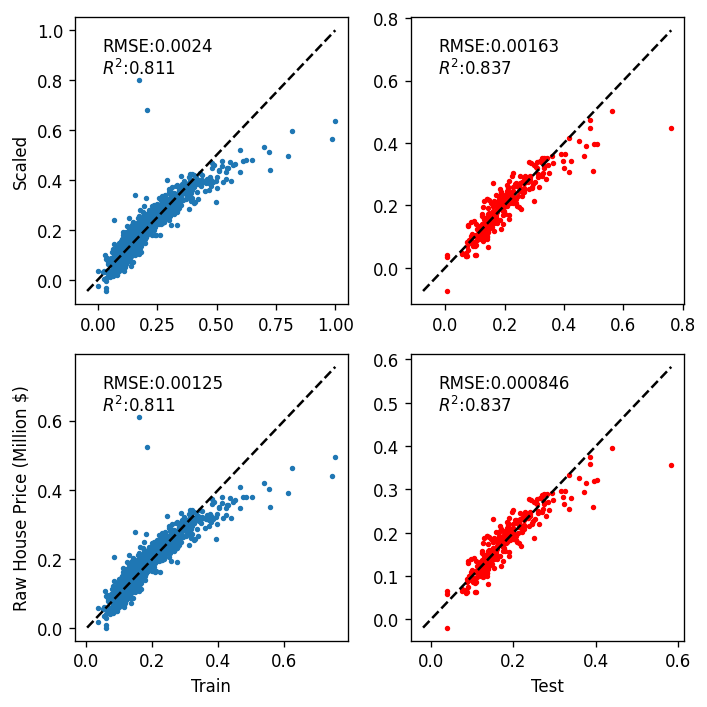

In [169]:
from sklearn.linear_model import LinearRegression
Linear_model = LinearRegression().fit(x_train,y_train)
model_quartet_plot(Linear_model)

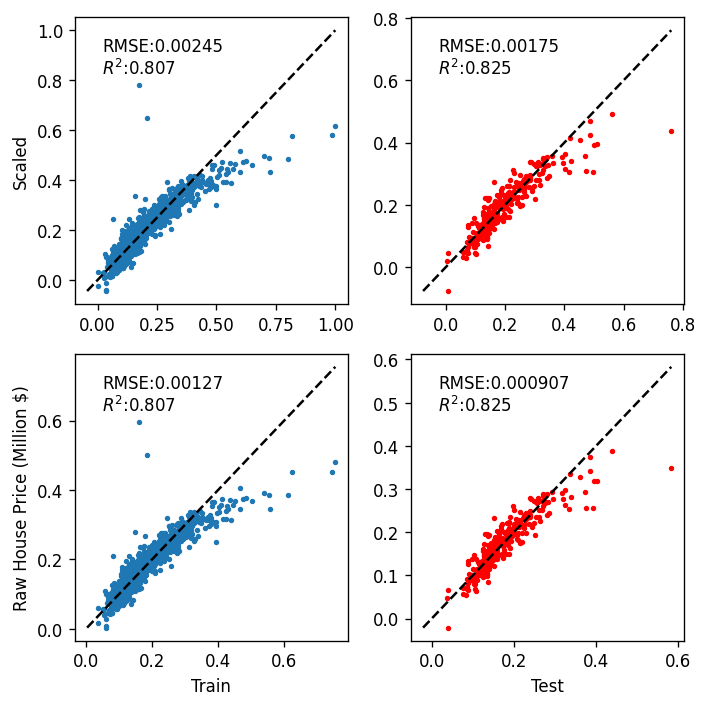

In [170]:
from sklearn.linear_model import LassoCV
Lasso_model = LassoCV(normalize = False).fit(x_train,y_train.ravel())
model_quartet_plot(Lasso_model)

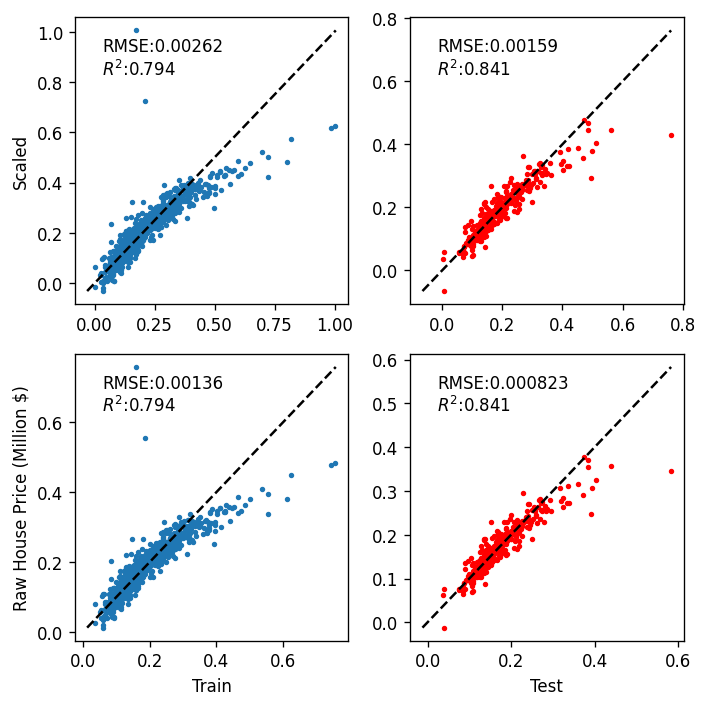

In [177]:
from sklearn.linear_model import HuberRegressor
Huber_model = HuberRegressor(max_iter = 500).fit(x_train,y_train.ravel())
model_quartet_plot(Huber_model)

### Fully Connected NN

In [235]:
from tensorflow import keras
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2
model = Sequential()
model.add(Dense(150,activation = 'relu',input_shape = (36,)))
#model.add(Dropout(rate = 0.1))
model.add(Dense(150,activation = 'relu'))
model.add(Dense(100,activation = 'relu'))
model.add(Dense(50,activation = 'relu'))
model.add(Dense(1,activation = 'relu'))
model.compile(optimizer = Adam(learning_rate = 5e-5),loss = 'huber')

In [236]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 150)               5550      
_________________________________________________________________
dropout_9 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_79 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_80 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 51        
Total params: 48,401
Trainable params: 48,401
Non-trainable params: 0
_________________________________________________

In [238]:
model.fit(x_train,y_train,epochs = 30,batch_size = 1)

Epoch 1/30
1168/1168 [==============================] - 1s 785us/step - loss: 0.0012
Epoch 2/30
1168/1168 [==============================] - 1s 794us/step - loss: 0.0011
Epoch 3/30
1168/1168 [==============================] - 1s 784us/step - loss: 0.0010
Epoch 4/30
1168/1168 [==============================] - 1s 804us/step - loss: 0.0010
Epoch 5/30
1168/1168 [==============================] - 1s 804us/step - loss: 9.6591e-04
Epoch 6/30
1168/1168 [==============================] - 1s 804us/step - loss: 0.0010
Epoch 7/30
1168/1168 [==============================] - 1s 785us/step - loss: 8.0903e-04
Epoch 8/30
1168/1168 [==============================] - 1s 795us/step - loss: 8.5345e-04
Epoch 9/30
1168/1168 [==============================] - 1s 796us/step - loss: 8.0708e-04
Epoch 10/30
1168/1168 [==============================] - 1s 768us/step - loss: 7.7001e-04
Epoch 11/30
1168/1168 [==============================] - 1s 802us/step - loss: 9.1673e-04
Epoch 12/30
1168/1168 [================

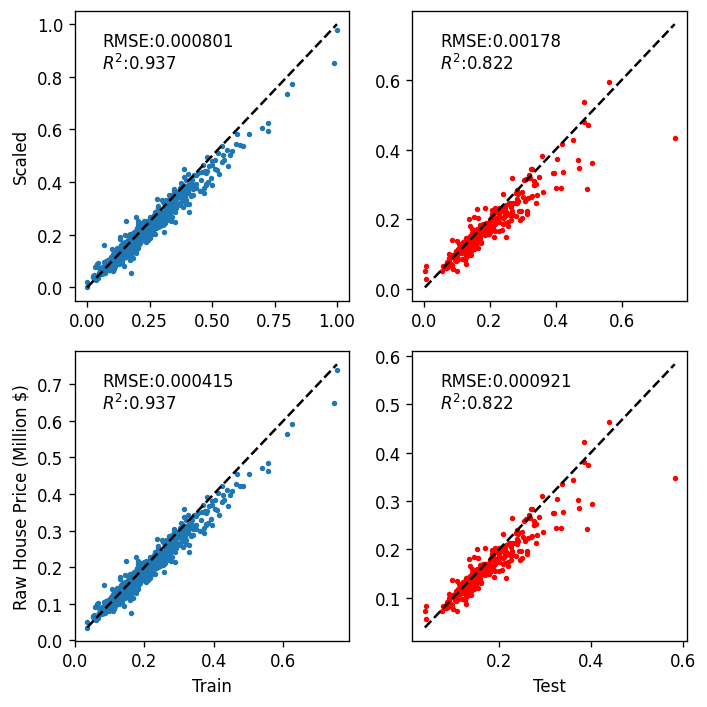

In [239]:
model_quartet_plot(model)

In [56]:
print('rmse :',rmse(model.predict(x_test),y_test))

rmse : 0.0026610630159403913


### KNN

8


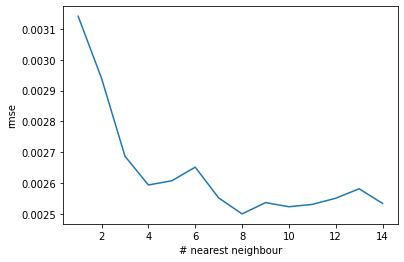

In [240]:
from sklearn.neighbors import KNeighborsRegressor as Knn
n_levels = 15
candidate_rmse = []
for i in range(1,n_levels):
    knn_model = Knn(i)
    knn_model.fit(x_train,y_train)
    candidate_rmse.append(rmse(knn_model.predict(x_test),y_test))
n = np.array(candidate_rmse).argmin() + 1
print(n)
plt.plot(range(1,n_levels),candidate_rmse)
plt.ylabel('rmse')
plt.xlabel('# nearest neighbour')
pass

In [241]:
knn_model = Knn(n)
knn_model.fit(x_train,y_train)
knn_preds = knn_model.predict(x_test)

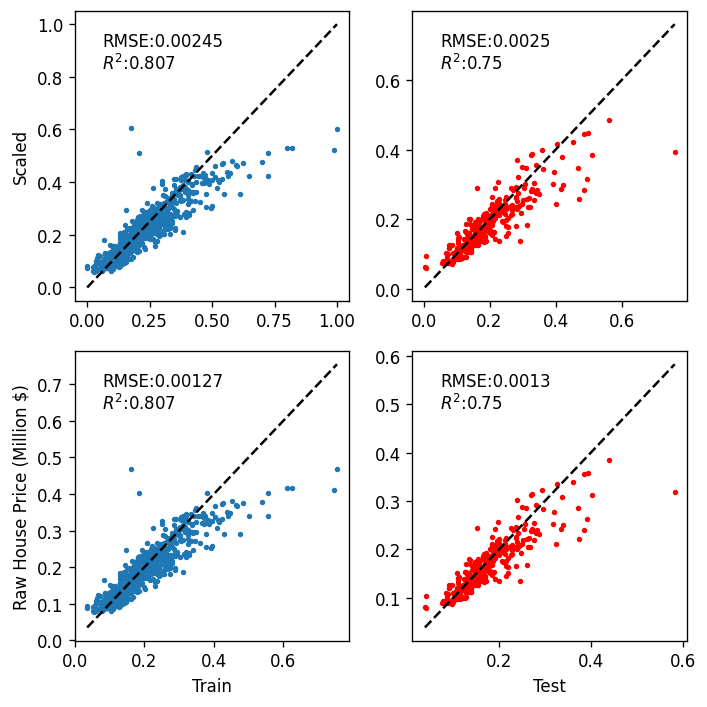

In [242]:
model_quartet_plot(knn_model)

In [243]:
print('rmse :',rmse(knn_preds,test_y))

NameError: name 'test_y' is not defined

### Random Forest

In [244]:
from sklearn.ensemble import RandomForestRegressor as Rfr


In [245]:
from sklearn.model_selection import GridSearchCV
parameters = {'criterion' : ['mse', 'poisson'],
              'n_estimators' : [60,80,100,120,140],
              'max_depth' : [25,30,36],
              'max_features' : [6,8,10,12,14],
              #min_samples_split' : [2,4,6,8]
             }
cand_rfr = Rfr()
grid_rf = GridSearchCV(cand_rfr,parameters,n_jobs = 8,verbose = 1)
#default 5-fold cross validation
grid_rf.fit(x_train,y_train.ravel())


Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=8,
             param_grid={'criterion': ['mse', 'poisson'],
                         'max_depth': [25, 30, 36],
                         'max_features': [6, 8, 10, 12, 14],
                         'n_estimators': [60, 80, 100, 120, 140]},
             verbose=1)

In [246]:
res = pd.DataFrame(grid_rf.cv_results_)

In [247]:
res.drop(columns = ['std_fit_time','mean_score_time','std_score_time','split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score','std_test_score'],inplace = True)
res

,mean_fit_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,mean_test_score,rank_test_score
0,0.136973,mse,25,6,60,"{'criterion': 'mse', 'max_depth': 25, 'max_fea...",0.849661,51
1,0.162809,mse,25,6,80,"{'criterion': 'mse', 'max_depth': 25, 'max_fea...",0.849019,55
2,0.210500,mse,25,6,100,"{'criterion': 'mse', 'max_depth': 25, 'max_fea...",0.849261,52
3,0.251934,mse,25,6,120,"{'criterion': 'mse', 'max_depth': 25, 'max_fea...",0.847044,69
4,0.306622,mse,25,6,140,"{'criterion': 'mse', 'max_depth': 25, 'max_fea...",0.852174,27
...,...,...,...,...,...,...,...,...
145,0.526239,poisson,36,14,60,"{'criterion': 'poisson', 'max_depth': 36, 'max...",0.474108,104
146,0.680729,poisson,36,14,80,"{'criterion': 'poisson', 'max_depth': 36, 'max...",0.469137,106
147,0.878843,poisson,36,14,100,"{'criterion': 'poisson', 'max_depth': 36, 'max...",0.467471,107
148,1.032158,poisson,36,14,120,"{'criterion': 'poisson', 'max_depth': 36, 'max...",0.466587,109


<AxesSubplot:xlabel='param_criterion'>

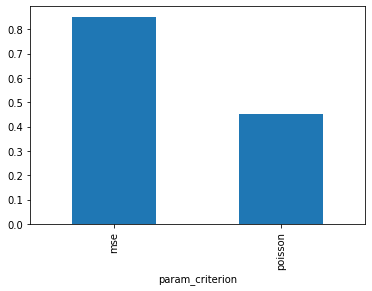

In [248]:
res.groupby('param_criterion').mean()['mean_test_score'].plot(kind = 'bar')

<AxesSubplot:xlabel='param_max_depth'>

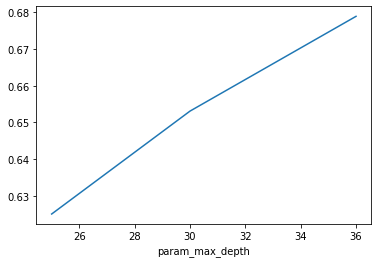

In [249]:
res.groupby('param_max_depth').mean()['mean_test_score'].plot()

<AxesSubplot:xlabel='param_max_features'>

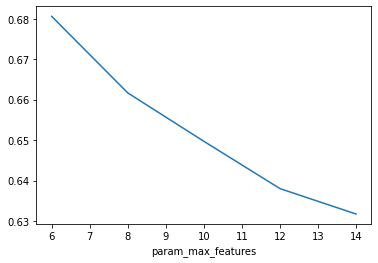

In [250]:
res.groupby('param_max_features').mean()['mean_test_score'].plot()

<AxesSubplot:xlabel='param_n_estimators'>

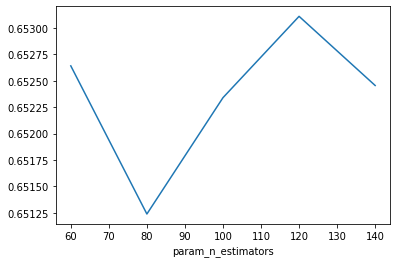

In [251]:
res.groupby('param_n_estimators').mean()['mean_test_score'].plot()

In [94]:
grid_rf.best_params_

{'criterion': 'mse',
 'max_depth': 36,
 'max_features': 10,
 'min_samples_split': 2,
 'n_estimators': 120}

In [ ]:
rfr = Rfr(50,max_depth = 12,min_samples_leaf = 2,max_features = 30)
rfr.fit(train_x,train_y.ravel())
rfr_preds = rfr.predict(test_x)
fig,ax = plt.subplots()
plt.scatter(test_y,rfr_preds)
ax.plot([test_y.min(),test_y.max()],[test_y.min(),test_y.max()],'k--')
plt.ylabel('Predicted')
plt.xlabel('True')

In [ ]:
print(rmse(rfr_preds,test_y))